In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import datetime

import torch

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
import numpy as np
import pickle
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from utils import *

from models import caranet
from unet import pretrained_unet

from metrics import DiceLoss

In [9]:
##### Hyperparameter Settings ####
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-4
weight_decay = 1e-10
batch_size = 16
num_epochs = 1000
early_stopping_patience = 10
random_seed = 42
date_time = datetime.datetime.now().strftime("%m-%d_%H-%M")

# model_type = 'caranet'
model_type = 'unet'

filename = f'models/{model_type}_{date_time}.pt'

if model_type == 'unet':
    mode = 'base'
elif model_type == 'caranet':
    mode = 'caranet'
#################################

In [7]:
transform = A.Compose([
    ToTensorV2(transpose_mask=True)
])

In [10]:
train_loader, val_loader = make_dataloader('both', transform , random_seed, batch_size, mode)

(1600, 400, 400, 3) (1600, 400, 400, 1)
(200, 400, 400, 3) (200, 400, 400, 1)


In [17]:
img, target = next(iter(val_loader))
img = img.to(device)
target = target.to(device)

In [21]:
img.shape

torch.Size([16, 3, 400, 400])

In [13]:
if model_type == 'unet':
    model = pretrained_unet(True).to(device)
elif model_type == 'caranet':
    model = caranet().to(device)

In [15]:
filename = 'models/unet_12-01_15-41.pt'
model.load_state_dict(torch.load(f'{filename}'))

<All keys matched successfully>

In [24]:
y_pred = model(img.float())

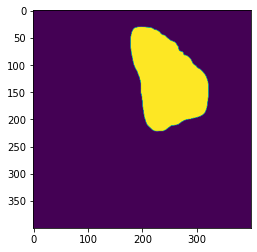

In [36]:
plt.imshow(y_pred[0].cpu().detach().numpy().transpose(1,2,0))
plt.show()

In [39]:
import torchvision.transforms as transforms

In [ ]:
def resize_return(y_pred, cutoff, originsize): ## cutoff, originsize
    h, w = originsize
    h += cutoff
    inverse = transforms.Compose([transforms.Pad(padding=(88,0), fill=0), ## padding size == 88 ? 확인 필요
                                 transforms.Resize((h,w)),
                                 transforms.Pad(padding=(0,cutoff,0,0), fill=0)]) 
    
    y_pred_inverse = inverse(y_pred)
    return y_pred_inverse